<a href="https://colab.research.google.com/github/nv-hiep/object_detection/blob/main/Step1_Bounding_box_with_OpenCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bounding box regression with OpenCV

# Connect and authorize google drive with google colab:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive	sample_data


In [ ]:
%cd /content/gdrive/My Drive/Colab Notebooks/object_detection
!ls

/content/gdrive/My Drive/Colab Notebooks/object_detection
 101_ObjectCategories
 Annotations
'Bounding box regression with Keras, TensorFlow, and Deep Learning.ipynb'
'Bounding box with OpenCV.ipynb'
 data_Motorbikes.csv
 logo.png
 model
 plots
 test


# Libraries

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import os
import glob
import time
import csv
import cv2

import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.patches as patches
from google.colab.patches import cv2_imshow

from PIL import Image
from scipy.io import loadmat


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
import imutils
from imutils.contours import sort_contours

#1. Caltech 101 dataset

## 1.1 Data directories

In [ ]:
# APP_PATH = !pwd
APP_PATH  = '/content/gdrive/My Drive/Colab Notebooks/object_detection'
DATA_PATH = os.path.join(APP_PATH, '101_ObjectCategories')
ANN_PATH  = os.path.join(APP_PATH, 'Annotations') 

print('Project path: ', APP_PATH)
print('Data path: ', DATA_PATH)
print('Annotation path: ', ANN_PATH)

Project path:  /content/gdrive/My Drive/Colab Notebooks/object_detection
Data path:  /content/gdrive/My Drive/Colab Notebooks/object_detection/101_ObjectCategories
Annotation path:  /content/gdrive/My Drive/Colab Notebooks/object_detection/Annotations


In [ ]:
MODEL_PATH = os.path.join(APP_PATH, 'model')
PLOT_PATH = os.path.join(APP_PATH, 'plots')
TEST_PATH = os.path.join(APP_PATH, 'test')

print('Model path: ', MODEL_PATH)
print('Plot path: ', PLOT_PATH)
print('Test path: ', TEST_PATH)

if not os.path.exists(MODEL_PATH):
  os.makedirs(MODEL_PATH)

if not os.path.exists(PLOT_PATH):
  os.makedirs(PLOT_PATH)

if not os.path.exists(TEST_PATH):
  os.makedirs(TEST_PATH)

Model path:  /content/gdrive/My Drive/Colab Notebooks/object_detection/model
Plot path:  /content/gdrive/My Drive/Colab Notebooks/object_detection/plots
Test path:  /content/gdrive/My Drive/Colab Notebooks/object_detection/test


##1.2 All labels and annotations

In [ ]:
# subdirectories in 101_ObjectCategories
dirs   = glob.glob( os.path.join(DATA_PATH, '*') )
labels = [x.split('/')[-1] for x in dirs]
print('Number of labels: ', len(labels))
print('Some examples: ', labels)

Number of labels:  102
Some examples:  ['bonsai', 'anchor', 'barrel', 'beaver', 'bass', 'BACKGROUND_Google', 'airplanes', 'ant', 'accordion', 'binocular', 'brontosaurus', 'butterfly', 'brain', 'cellphone', 'chair', 'car_side', 'cannon', 'ceiling_fan', 'buddha', 'camera', 'dollar_bill', 'dalmatian', 'chandelier', 'cup', 'cougar_body', 'crocodile', 'crab', 'cougar_face', 'crayfish', 'crocodile_head', 'Faces_easy', 'ferry', 'dolphin', 'Faces', 'euphonium', 'emu', 'electric_guitar', 'elephant', 'ewer', 'dragonfly', 'garfield', 'headphone', 'grand_piano', 'helicopter', 'flamingo', 'gramophone', 'hedgehog', 'hawksbill', 'flamingo_head', 'gerenuk', 'ibis', 'joshua_tree', 'lobster', 'kangaroo', 'inline_skate', 'lamp', 'ketch', 'llama', 'Leopards', 'laptop', 'Motorbikes', 'metronome', 'okapi', 'nautilus', 'mandolin', 'mayfly', 'lotus', 'octopus', 'menorah', 'minaret', 'saxophone', 'pagoda', 'panda', 'pizza', 'rhino', 'pigeon', 'rooster', 'revolver', 'pyramid', 'platypus', 'schooner', 'stop_sign

In [ ]:
# subdirectories in Annotations
dirs = glob.glob( os.path.join(ANN_PATH, '*') )
anns = [x.split('/')[-1] for x in dirs]
print('Number of Annotations: ', len(anns))
print('Some examples: ', anns)

Number of Annotations:  106
Some examples:  ['progress.mat', 'README', 'README~', 'FeatureDetectionQuality.mat', 'check_progress.mat', 'Airplanes_Side_2', 'ant', 'brain', 'anchor', 'beaver', 'bass', 'binocular', 'bonsai', 'accordion', 'barrel', 'chair', 'butterfly', 'cellphone', 'camera', 'buddha', 'car_side', 'ceiling_fan', 'chandelier', 'cannon', 'brontosaurus', 'cougar_face', 'cougar_body', 'dolphin', 'crocodile', 'dalmatian', 'crab', 'cup', 'dollar_bill', 'crocodile_head', 'crayfish', 'flamingo', 'electric_guitar', 'Faces_2', 'ferry', 'dragonfly', 'ewer', 'Faces_3', 'elephant', 'euphonium', 'emu', 'helicopter', 'gerenuk', 'headphone', 'flamingo_head', 'gramophone', 'hawksbill', 'grand_piano', 'ibis', 'garfield', 'hedgehog', 'llama', 'joshua_tree', 'ketch', 'lotus', 'inline_skate', 'lobster', 'lamp', 'Leopards', 'laptop', 'kangaroo', 'octopus', 'mayfly', 'minaret', 'Motorbikes_16', 'pagoda', 'metronome', 'nautilus', 'okapi', 'menorah', 'mandolin', 'rhino', 'pigeon', 'pizza', 'schoon

##1.3 Label: Motorbikes

In [ ]:
mylabel_img = 'Motorbikes'
mylabel_ann = 'Motorbikes_16'

img_samples = glob.glob( os.path.join(DATA_PATH, mylabel_img, '*') )
print('Number of sample images: ', len(img_samples))
print(img_samples[:5])

ann_samples = glob.glob( os.path.join(ANN_PATH, mylabel_ann, '*') )
print('Number of sample annotations: ', len(ann_samples))
print(ann_samples[:5])

Number of sample images:  798
['/content/gdrive/My Drive/Colab Notebooks/object_detection/101_ObjectCategories/Motorbikes/image_0026.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/101_ObjectCategories/Motorbikes/image_0020.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/101_ObjectCategories/Motorbikes/image_0024.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/101_ObjectCategories/Motorbikes/image_0031.jpg', '/content/gdrive/My Drive/Colab Notebooks/object_detection/101_ObjectCategories/Motorbikes/image_0010.jpg']
Number of sample annotations:  798
['/content/gdrive/My Drive/Colab Notebooks/object_detection/Annotations/Motorbikes_16/annotation_0093.mat', '/content/gdrive/My Drive/Colab Notebooks/object_detection/Annotations/Motorbikes_16/annotation_0061.mat', '/content/gdrive/My Drive/Colab Notebooks/object_detection/Annotations/Motorbikes_16/annotation_0039.mat', '/content/gdrive/My Drive/Colab Notebooks/object_detection/Annotations/M

In [ ]:
# Read an annotation file
annotations = loadmat(ann_samples[0])
annotations

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Wed Dec 08 18:42:40 2004',
 '__version__': '1.0',
 'box_coord': array([[ 25, 120,  34, 228]], dtype=uint8),
 'obj_contour': array([[  0.86838791,  10.69206549,  19.77896725,  31.81297229,
          43.35579345,  47.28526448,  73.31801008,  75.03715365,
          89.52707809, 106.96410579, 118.75251889, 129.31297229,
         137.17191436, 143.55730479, 151.17065491, 149.69710327,
         160.50314861, 166.6429471 , 166.15176322, 163.20465995,
         157.3104534 , 157.3104534 , 158.29282116, 165.16939547,
         175.48425693, 183.09760705, 188.9918136 , 193.90365239,
         195.13161209, 192.18450882, 183.83438287, 174.01070529,
         157.80163728, 146.01322418, 142.08375315, 136.43513854,
         135.45277078, 131.03211587, 121.69962217, 108.19206549,
          89.28148615,  62.2663728 ,  51.21473552,  40.40869018,
          26.65554156,  14.37594458,   5.7802267 ,   2.58753149,
          

Plot some samples with their true bounding boxes

Image shape: (180, 275, 3)
Image shape: (159, 263, 3)
Image shape: (153, 263, 3)
Image shape: (150, 265, 3)


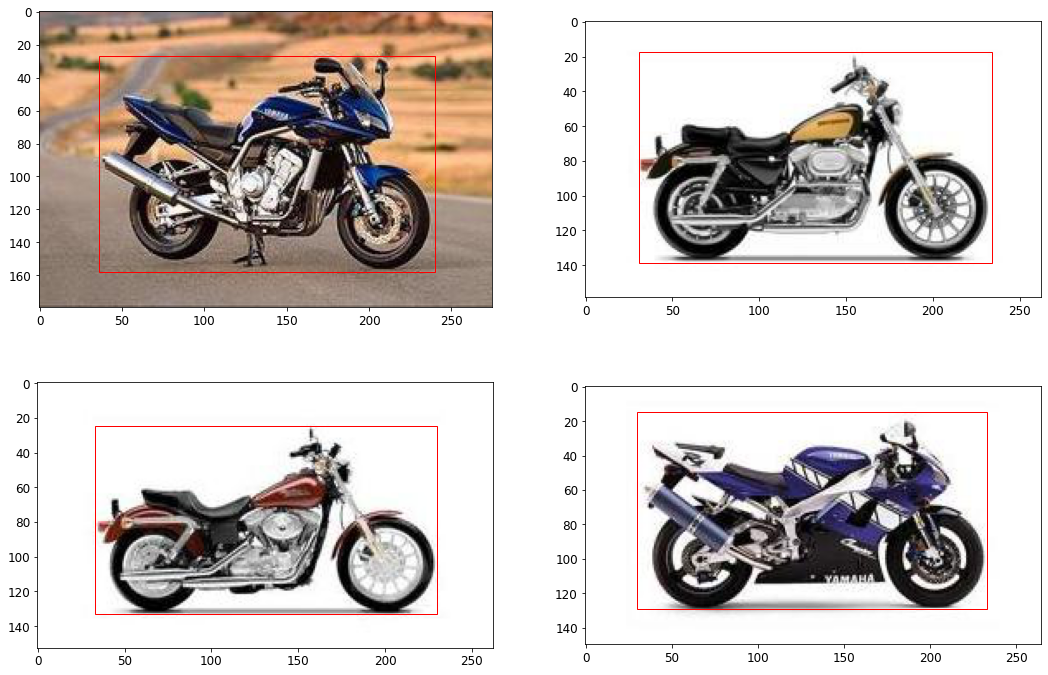

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(18,12))
axs = axs.flatten()

for i in range(4):
  ximg   = Image.open(img_samples[i])
  img_id = img_samples[i].split('/')[-1].replace('.jpg', '').replace('image_', '')
  print(f'Image shape: {np.array(ximg).shape}')
  axs[i].imshow(ximg)

  ann_file     = os.path.join(ANN_PATH, mylabel_ann, 'annotation_' + img_id + '.mat')
  (y, h, x, w) = loadmat(ann_file)['box_coord'][0]

  rect = patches.Rectangle( (x, y), w-x, h-y, linewidth=1, edgecolor='r', facecolor='none')  
  axs[i].add_patch(rect)

plt.show()

#2. Bounding box with OpenCV

##2.1 Load image and its true bounding box

In [ ]:
IMG_ID = 3

In [ ]:
ximg   = Image.open(img_samples[IMG_ID])
img_id = img_samples[IMG_ID].split('/')[-1].replace('.jpg', '').replace('image_', '')
shapes = np.array(ximg).shape
print(f'Image shape: {shapes}')

ann_file     = os.path.join(ANN_PATH, mylabel_ann, 'annotation_' + img_id + '.mat')
(y, h, x, w) = loadmat(ann_file)['box_coord'][0]

Image shape: (150, 265, 3)


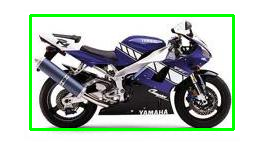

In [ ]:
img       = cv2.imread(img_samples[IMG_ID], cv2.IMREAD_COLOR)
original  = img.copy()
img_final = img.copy()

# draw the predicted bounding box on the image
cv2.rectangle(img, (x, y), (w, h), (0, 255, 0), 2)

cv2_imshow(img)

cv2.waitKey(0)
cv2.destroyAllWindows()

##2.2 Find bounding box

In [ ]:
# grayscale, Otsu's threshold 
gray    = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

In [ ]:
# Find contours, obtain bounding box, extract and save ROI
WIDTH_LIM1  = 0.2  # percent
WIDTH_LIM2  = 0.95 # percent
HEIGHT_LIM1 = 0.2  # percent
HEIGHT_LIM2 = 0.95 # percent

conts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
conts = conts[0] if len(conts) == 2 else conts[1]

boxes = []
for cntr in conts:
  xi, yi, wi, hi = cv2.boundingRect(cntr)
  
  # filter out bounding boxes, ensuring they are neither too small nor too large
  # You may need to change these numbers according to your images/requirements
  if (wi >= WIDTH_LIM1*shapes[1] and wi <= WIDTH_LIM2*shapes[1]) and (hi >= HEIGHT_LIM1*shapes[0] and hi <= HEIGHT_LIM2*shapes[0]):
    cv2.rectangle(original, (xi, yi), (xi+wi, yi+hi), (0, 0, 255), 2)
    print('x, y, w, h: ', xi, yi, wi, hi)

    boxes.append( (xi, yi, wi, hi)  )

    # cv2.imwrite('data/ROI_{}.png'.format(ROI_number), original)
    # cv2.imwrite('two_blobs_result.jpg', original)
# End - for

print('ROI number: ', len(boxes))

x, y, w, h:  37 22 194 108
ROI number:  1


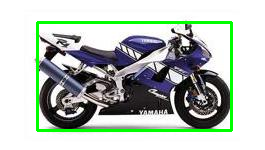

In [ ]:
# loop over the predictions and bounding box locations together
for (x, y, w, h) in boxes:
  cv2.rectangle(original, (x, y), (x + w, y + h), (0, 255, 0), 2)
  # cv2.putText(image, label, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

# show the image
# cv2.imshow("Image", image)
cv2_imshow(original)
# cv2.waitKey(0)

##2.3 Final box

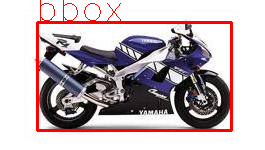

In [ ]:
bbox = boxes[0]
for (x, y, w, h) in boxes[1:]:
  if w*h > bbox[2]*bbox[3]:
    bbox = (x, y, w, h)

# show the image
(x, y, w, h) = bbox
cv2.rectangle(img_final, (x, y), (x + w, y + h), (0, 0, 255), 2)
cv2.putText(img_final, 'bbox', (x-2, y-2), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 1)
cv2_imshow(img_final)
# cv2.waitKey(0)